In [1]:
# Standard imports
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip, ImageSequenceClip, clips_array
import numpy as np
import os

# Project imports
from image_utils import abs_sobel_thresh, dir_thresh, mag_thresh, channel_thresh, warp_perspective
from camera import Camera
from laneline import Laneline

In [2]:
%matplotlib inline

In [3]:
# Some utility functions

def BGR2RGB(image):
    """Convert BGR image to RGB image"""
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb
            
def RGB2BGR(image):
    """Convert RGB image to BGR image"""
    bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return bgr

def parent_dir_from_file(filepath=None):
    if not filepath:
        filepath = os.path.abspath("__file__")
    return os.path.dirname(os.path.dirname(filepath))

def load_images_from_path_generator(directory, prefix='.jpg'):
    """Read in all images from the specified directory."""
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            yield cv2.imread(os.path.join(directory, filename))

def save_images_generator(images, prefix, directory):
    """
    Returns a generator which saves images and yields them back. 
    Note: filenames are created according to the pattern: `prefix` + '_' + `idx` + '.jpg'.
    """
    if not os.path.isdir(directory):
        os.makedirs(directory)
        
    for idx, image_list in enumerate(images):
        
        # If image_list is a tuple of images, only save the last one
        if isinstance(image_list, tuple):
            image = image_list[-1]
        # Otherwise, we don't actually have a list of images
        else:
            image = image_list
            
        pad = '0' * (10 - len(str(idx)))
        filename = prefix + '_' + pad + str(idx) + '.jpg'
        file_path = os.path.join(directory, filename)
        
        # Save binary images as 3d so that moviepy can still read them
        if len(image.shape) == 2:
            bgr = (np.dstack([image, image, image]) * 255).astype(np.uint8)
            cv2.imwrite(file_path, bgr)
        else:
            cv2.imwrite(file_path, image)
        yield image_list

In [4]:
# Define 'Command-Line' Parameters
LOAD_FROM_VIDEO = False
FRAMES_PER_SECOND = 10
SAVE_INTERMEDIATE_STEPS = True
SAVE_OUTPUT_IMAGES = True

# Define Project Root Path and Subfolders
root_path = parent_dir_from_file() # all scripts are in '/prj_root/scripts'
camera_path = os.path.join(root_path, 'camera')
calibration_folder = 'calibration_images'
video_path = os.path.join(root_path, 'test_videos')
video_filename = 'project_video.mp4'
video_image_path = os.path.join(video_path, 'undistorted')

# Create/load instance of Camera and calibrate it
my_camera = Camera('Udacity_Advanced_Lane_Line_Camera', camera_path)
if not my_camera.isCalibrated:
    print('Now calibrating camera...')
    my_camera.calibrate(calibration_folder, 6, 9)
    if my_camera.isCalibrated:
        print('Calibration successful! Saved camera to {0}'.format(my_camera.filename))
        my_camera.save()
    else:
        print('Calibration failed :/')
else:
    print('Calibrated camera loaded from {0}'.format(my_camera.filename))

Calibrated camera loaded from /home/dcato/CarND-Advanced-Lane-Lines/camera/Udacity_Advanced_Lane_Line_Camera.pkl


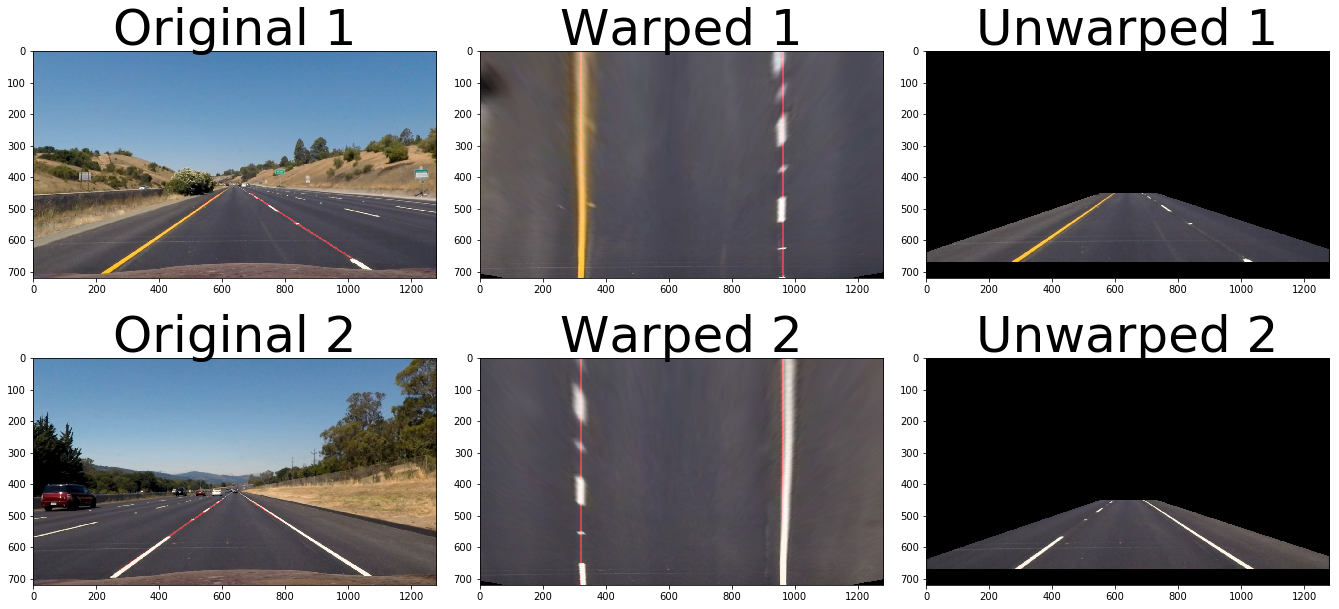

In [5]:
# Manually Calibrate the Perspective Transform
#  1) choose an image where the lane is straight and centered in the road
#  2) adjust source points until they bound the lane lines
#
#  Note: this simplistic transform assumes that the road is flat and the camera is always level 
#  (i.e. good enough for project, but probably want to improve this before putting on a real car)

# load calibration images, undistort them, and convert to RGB
straight_lines_path_1 = os.path.join(root_path, 'test_images', 'straight_lines1.jpg')
straight_lines_1 = BGR2RGB(my_camera.undistort_image(cv2.imread(straight_lines_path_1)))

straight_lines_path_2 = os.path.join(root_path, 'test_images', 'straight_lines2.jpg')
straight_lines_2 = BGR2RGB(my_camera.undistort_image(cv2.imread(straight_lines_path_2)))

# define source and destination perspective transform points
y, x, _ = straight_lines_1.shape
src = [[280, 670], [596, 450], [686, 450], [1030, 670]]
dest = [[int(x/4), y], [int(x/4), 0], [int(x*3/4), 0], [int(x*3/4), y]]

# draw perspective transform shapes
src_perspective_lines = np.zeros_like(straight_lines_1)
src_perspective_lines = cv2.polylines(src_perspective_lines, [np.array(src[0:2]), np.array(src[2:4])], 
                                      isClosed=0, color=(255, 0, 0), thickness=3)
dest_perspective_lines = np.zeros_like(straight_lines_1)
dest_perspective_lines = cv2.polylines(dest_perspective_lines, [np.array(dest[0:2]), np.array(dest[2:4])], 
                                       isClosed=0, color=(255, 0, 0), thickness=3)

# Draw source perspective transform lines on calibration images
overlaid_1 = cv2.addWeighted(straight_lines_1, 1, src_perspective_lines, 0.5, 0.0)
overlaid_2 = cv2.addWeighted(straight_lines_2, 1, src_perspective_lines, 0.5, 0.0)

# Get the perspective transforms
M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dest))
Minv = cv2.getPerspectiveTransform(np.float32(dest), np.float32(src))

# Get warped images and draw destination lines
warped_1 = cv2.warpPerspective(straight_lines_1, M, (x, y), flags=cv2.INTER_LINEAR)
warped_2 = cv2.warpPerspective(straight_lines_2, M, (x, y), flags=cv2.INTER_LINEAR)
warped_w_overlay_1 = cv2.addWeighted(warped_1, 1, dest_perspective_lines, 0.5, 0.0)
warped_w_overlay_2 = cv2.addWeighted(warped_2, 1, dest_perspective_lines, 0.5, 0.0)

unwarped_1 = cv2.warpPerspective(warped_1, Minv, (x, y), flags=cv2.INTER_LINEAR)
unwarped_2 = cv2.warpPerspective(warped_2, Minv, (x, y), flags=cv2.INTER_LINEAR)

# plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 9))
f.tight_layout()
ax1.imshow(overlaid_1)
ax1.set_title('Original 1', fontsize=50)
ax2.imshow(warped_w_overlay_1)
ax2.set_title('Warped 1', fontsize=50)
ax3.imshow(unwarped_1)
ax3.set_title('Unwarped 1', fontsize=50)
ax4.imshow(overlaid_2)
ax4.set_title('Original 2', fontsize=50)
ax5.imshow(warped_w_overlay_2)
ax5.set_title('Warped 2', fontsize=50)
ax6.imshow(unwarped_2)
ax6.set_title('Unwarped 2', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

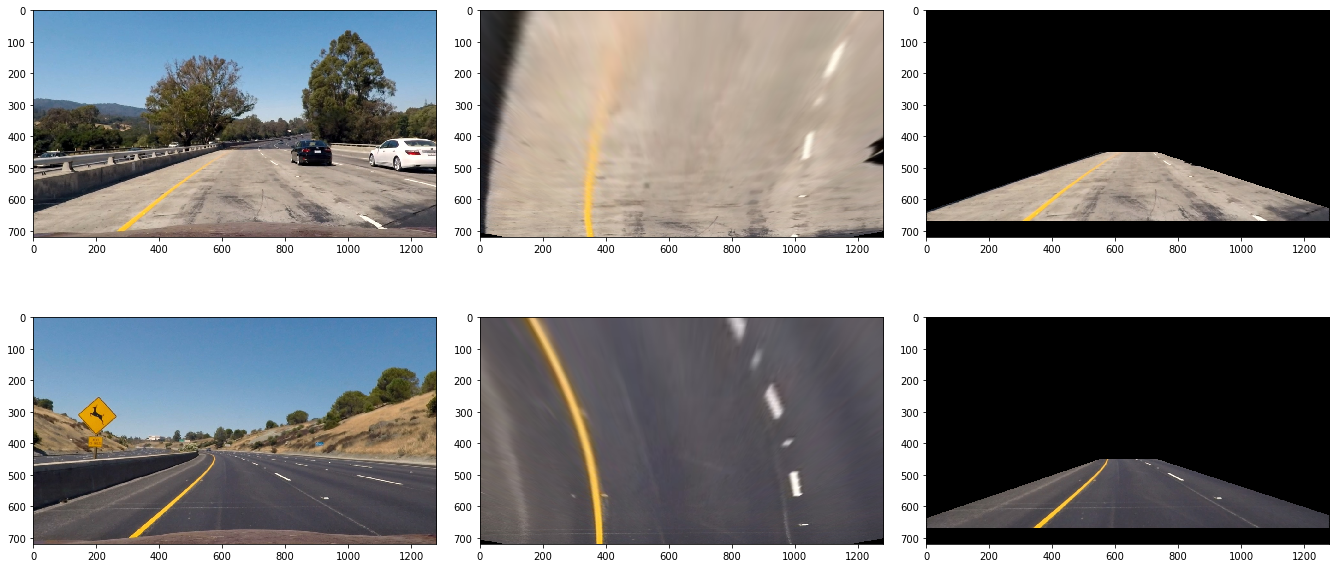

In [6]:
# Test Perspective Transform on Curved Roads
#
#  Note: The curved lines in each image should be roughly parallel. If
#         they're not, consider fine tuning the perspective transform above.

# Load the test images
test_1_path = os.path.join(root_path, 'test_images', 'test1.jpg')
test_1 = BGR2RGB(my_camera.undistort_image(cv2.imread(test_1_path)))
test_2_path = os.path.join(root_path, 'test_images', 'test2.jpg')
test_2 = BGR2RGB(my_camera.undistort_image(cv2.imread(test_2_path)))

# Warp the test images
test_warped_1 = cv2.warpPerspective(test_1, M, (x, y), flags=cv2.INTER_LINEAR)
test_warped_2 = cv2.warpPerspective(test_2, M, (x, y), flags=cv2.INTER_LINEAR)

# Unwarp the test images
unwarped_1 = cv2.warpPerspective(test_warped_1, Minv, (x, y), flags=cv2.INTER_LINEAR)
unwarped_2 = cv2.warpPerspective(test_warped_2, Minv, (x, y), flags=cv2.INTER_LINEAR)

# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 9))
f.tight_layout()
ax1.imshow(test_1)
ax2.imshow(test_warped_1)
ax3.imshow(unwarped_1)
ax4.imshow(test_2)
ax5.imshow(test_warped_2)
ax6.imshow(unwarped_2)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

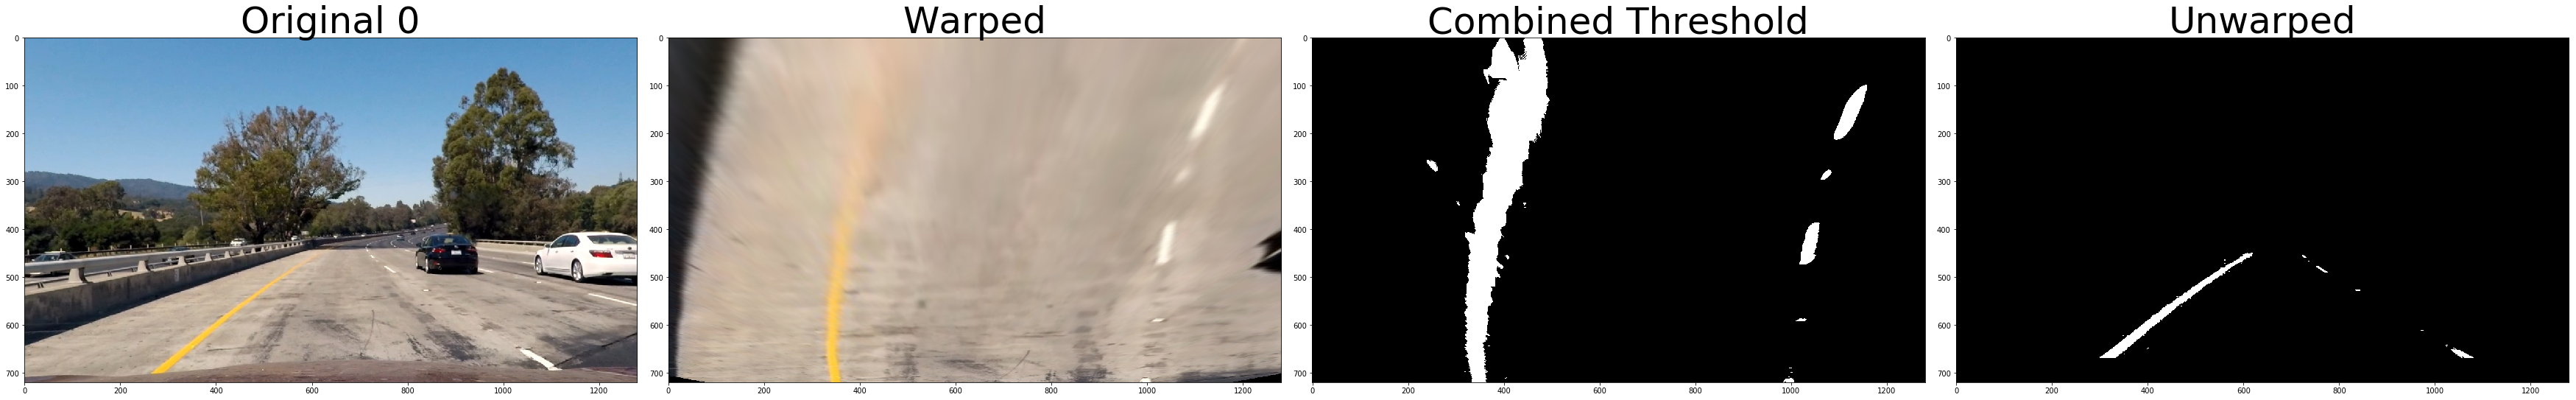

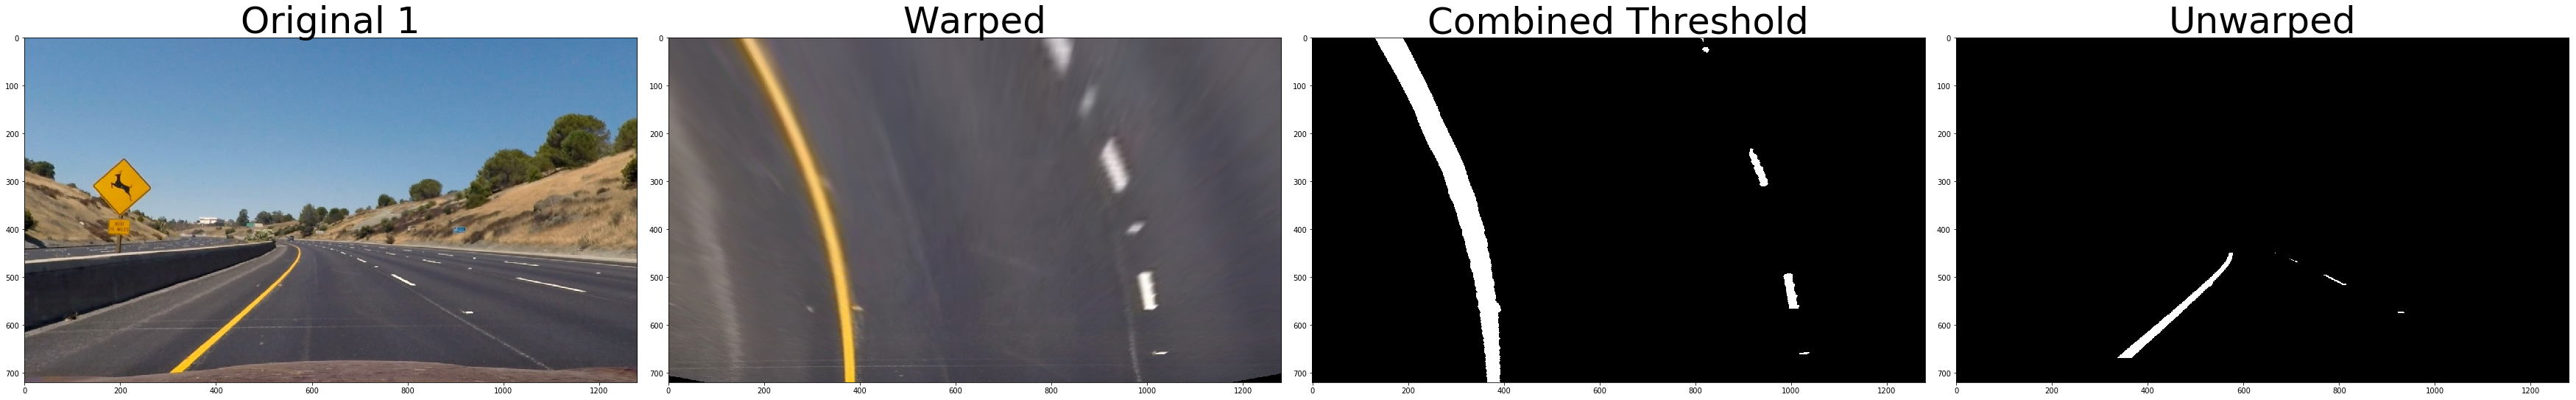

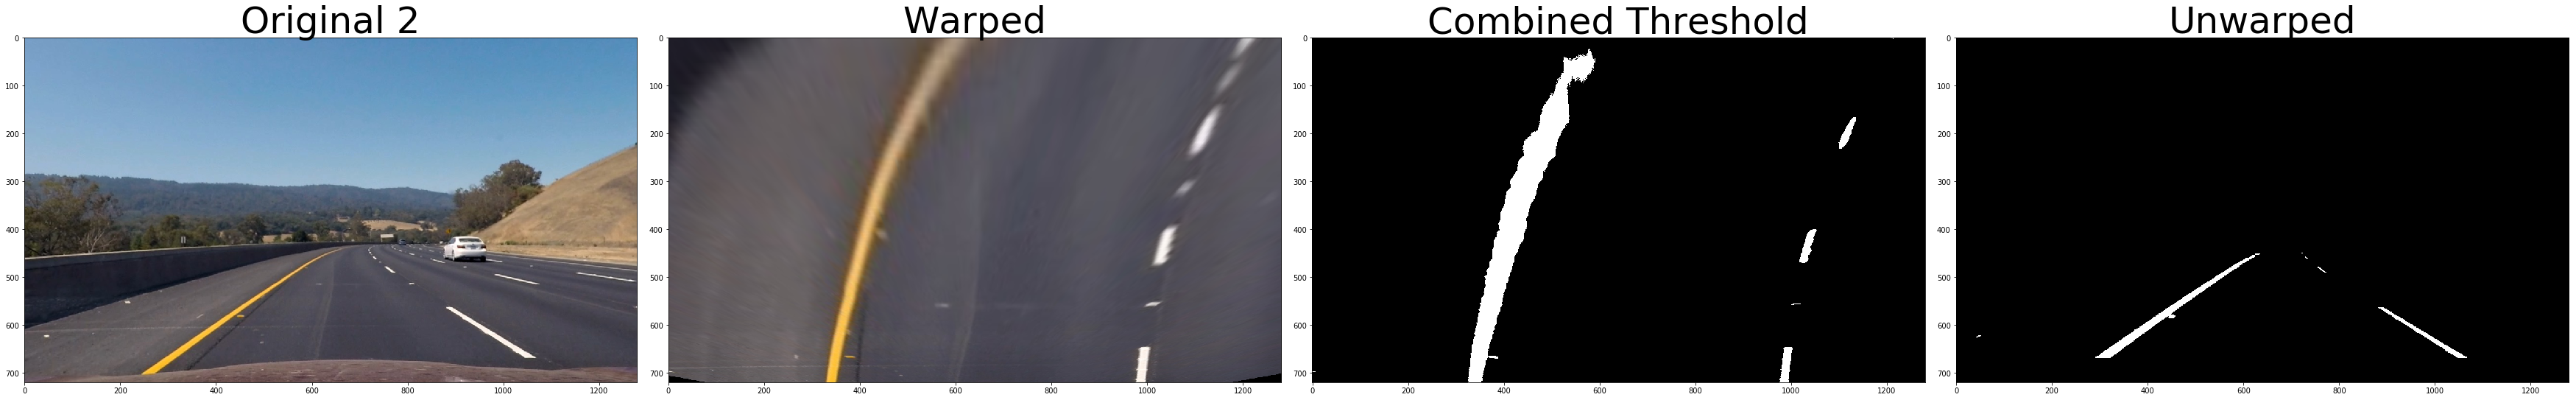

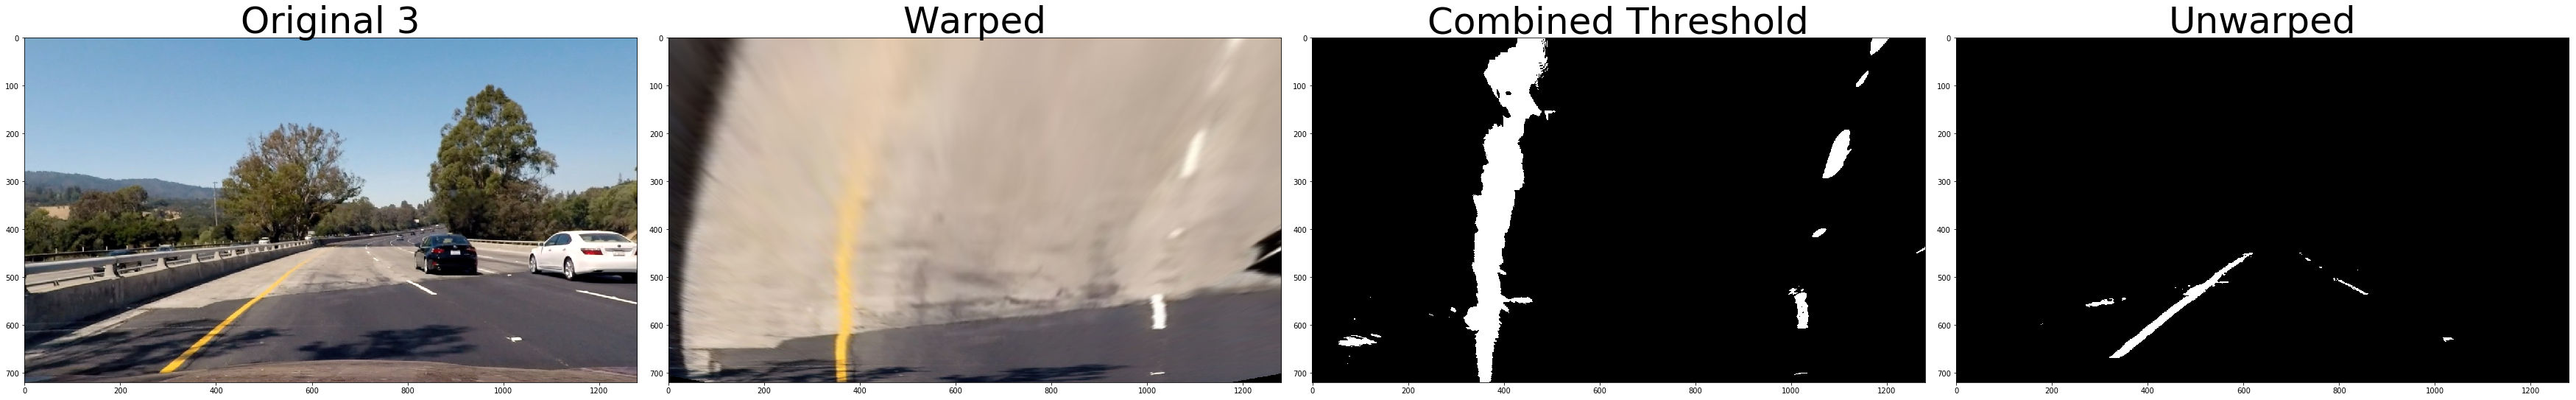

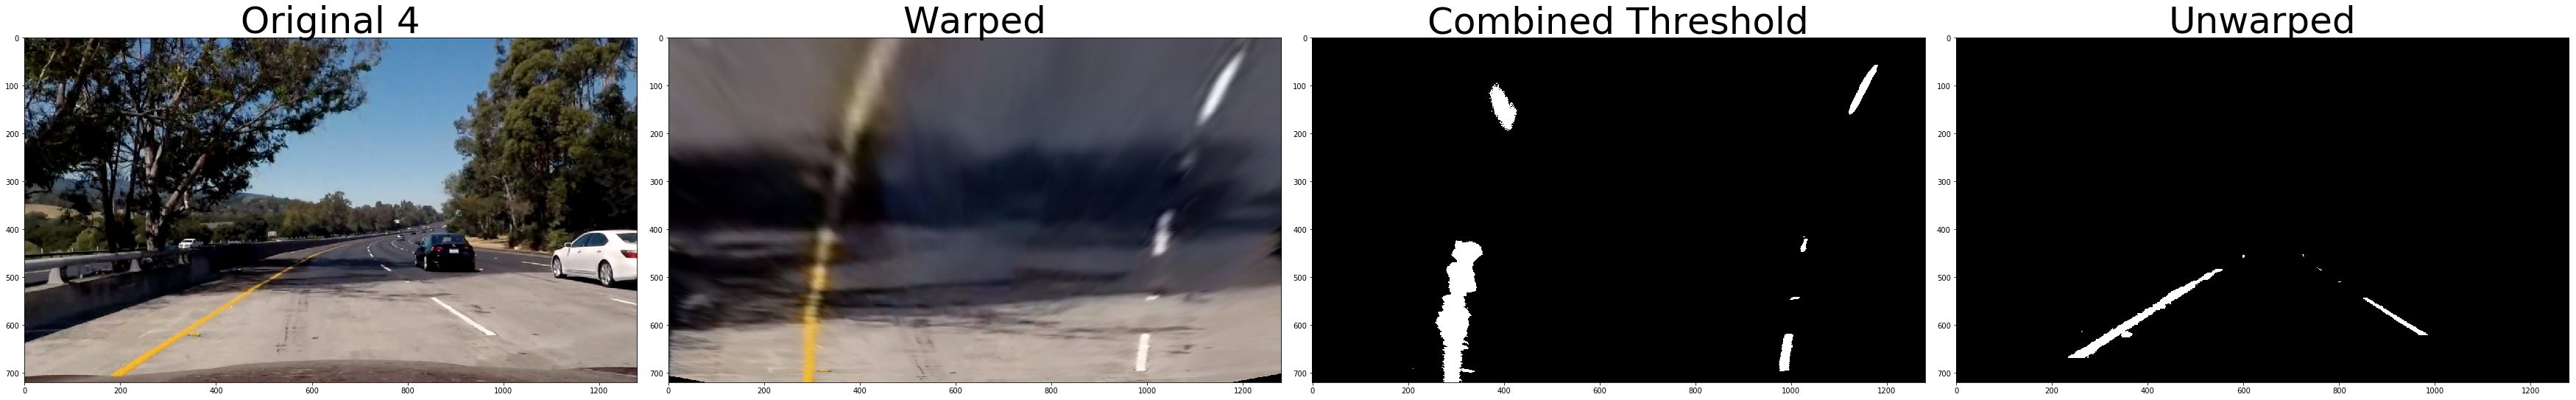

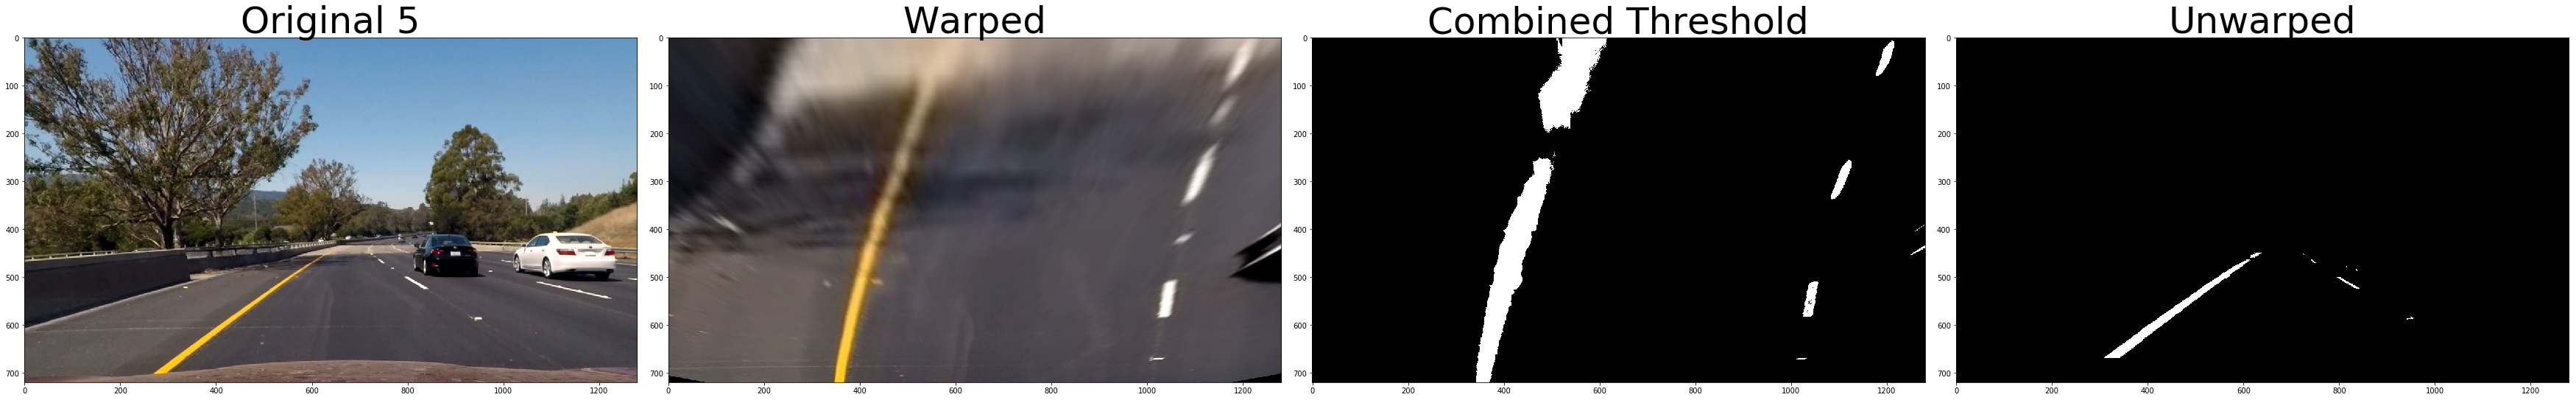

In [7]:
# Manually Calibrate the Lane Detection Threshold Parameters

# Choose what to plot
PLOT_INDIVIDUAL_THRESHOLDS = False
PLOT_FINAL_THRESHOLDS = True

# Load test images
image_list = ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
test_images = [None] * len(image_list)
threshed_images = [None] * len(test_images)
for i, filename in enumerate(image_list):
    image_path = os.path.join(root_path, 'test_images', filename)
    test_images[i] = my_camera.undistort_image(cv2.imread(image_path))

for i, image in enumerate(test_images):
    warped = cv2.warpPerspective(image, M, (x, y), flags=cv2.INTER_LINEAR)
    
    # Convert image to grayscale, HLS, and LUV
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    
    HLS_image = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS) # H: [0, 179] double-degrees, L&S: [0, 255]
    S_image = HLS_image[:,:,2]
    
    LUV_image = cv2.cvtColor(warped, cv2.COLOR_BGR2LUV) # H: [0, 179] double-degrees, L&S: [0, 255]
    L_image = LUV_image[:,:,0]
    
    LAB_image = cv2.cvtColor(warped, cv2.COLOR_BGR2LAB) # L: [0, 100], L&S: [-128, 128]
    B_image = LAB_image[:,:,2]

    # Apply each of the thresholding functions
    gradx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(25, 254))
    dir_gradx_binary = dir_thresh(gradx_binary, sobel_kernel=3, thresh=(np.pi/4-np.pi/8, np.pi/4+np.pi/8))
    grady_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=3, thresh=(25, 254))
    dir_grady_binary = dir_thresh(grady_binary, sobel_kernel=3, thresh=(np.pi/4-np.pi/8, np.pi/4+np.pi/8))
    mag_binary = mag_thresh(gray, sobel_kernel=5, mag_thresh=(25, 254))
    dir_binary = dir_thresh(gray, sobel_kernel=5, thresh=(np.pi/4-np.pi/8, np.pi/4+np.pi/8))
    S_binary = channel_thresh(S_image, thresh=(100,254))
    dir_S_binary = dir_thresh(S_binary, sobel_kernel=5, thresh=(np.pi/4-np.pi/8, np.pi/4+np.pi/8))
    
    L_binary = channel_thresh(L_image, thresh=(210,254))
    B_binary = channel_thresh(B_image, thresh=(145,254))

    # Create the combined threshold
    threshed_images[i] = np.zeros_like(image[:,:,0])
    threshed_images[i][(L_binary==1) | (B_binary==1)] = 1
    
    if PLOT_INDIVIDUAL_THRESHOLDS:
        f, s = plt.subplots(2, 4, figsize=(48, 18))
        ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = s
        f.tight_layout()
        ax1.imshow(BGR2RGB(warped))
        ax1.set_title('Original {0}'.format(i), fontsize=50)
        ax2.imshow(gradx_binary, cmap='gray')
        ax2.set_title('X-Threshold', fontsize=50)
        ax3.imshow(dir_gradx_binary, cmap='gray')
        ax3.set_title('Dir X-Threshold', fontsize=50)
        ax4.imshow(grady_binary, cmap='gray')
        ax4.set_title('Y-Threshold', fontsize=50)
        #ax5.imshow(dir_S_binary, cmap='gray')
        #ax5.set_title('Dir S-Threshold', fontsize=50)
        ax5.imshow(S_binary, cmap='gray')
        ax5.set_title('S-Threshold', fontsize=50)
        #ax6.imshow(dir_binary, cmap='gray')
        #ax6.set_title('Direction Threshold', fontsize=50)
        ax6.imshow(B_binary, cmap='gray')
        ax6.set_title('B-Threshold', fontsize=50)
        #ax7.imshow(threshed_images[i], cmap='gray')
        #ax7.set_title('Combined Threshold', fontsize=50)
        ax7.imshow(L_binary, cmap='gray')
        ax7.set_title('L-Threshold', fontsize=50)
        ax8.imshow(dir_grady_binary, cmap='gray')
        ax8.set_title('Dir Y-Threshold', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    
    if PLOT_FINAL_THRESHOLDS:
        # Get warped and unwarped images
        unwarped = cv2.warpPerspective(threshed_images[i], Minv, (x, y), flags=cv2.INTER_LINEAR)

        # Plot the result
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(48, 9))
        f.tight_layout()
        ax1.imshow(BGR2RGB(image))
        ax1.set_title('Original {0}'.format(i), fontsize=50)
        ax2.imshow(BGR2RGB(warped))
        ax2.set_title('Warped', fontsize=50)
        ax3.imshow(threshed_images[i], cmap='gray')
        ax3.set_title('Combined Threshold', fontsize=50)
        ax4.imshow(unwarped, cmap='gray')
        ax4.set_title('Unwarped', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

In [8]:
# Create the Threshold Generator Using Manually Tuned Threshold Parameters

def threshold_generator(images):
    """Returns a tuple containing the original image and a binary thresholded image."""
    for image in images:
        original = image[0]
        warped = image[-1]
        
        # Convert image to LUV and LAB
        LUV_image = cv2.cvtColor(warped, cv2.COLOR_BGR2LUV) # H: [0, 179], L&S: [0, 255]
        LAB_image = cv2.cvtColor(warped, cv2.COLOR_BGR2LAB) # L: [0, 100], L&S: [0, 255]
        L_image = LUV_image[:,:,0]
        B_image = LAB_image[:,:,2]
        
        # Apply each of the thresholding functions
        L_binary = channel_thresh(L_image, thresh=(210,254))
        B_binary = channel_thresh(B_image, thresh=(145,254))

        # Combine L and B to create threshed image
        threshed = np.zeros_like(warped[:,:,0])
        threshed[(L_binary==1) | (B_binary==1)] = 1
        
        yield (original, threshed)

In [9]:
def find_lane_lines(image, n_windows=9, margin=100, minpix=50):
    """
    Search for lane lines using a sliding window search.
    
    Parameters:
        image - binary image which contains lane lines
        n_windows - number of search windows
        margin - width of each search window
        minpix - minimum number of pixels to recenter the search window
    
    Returns
        (left_x, left_y, right_x, right_y) - A tuple containing the pixel coordinates of the left and right lane lines.
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0]//2
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Current positions to be updated for each window
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    # Set height of windows
    window_height = image.shape[0]//n_windows
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero_y, nonzero_x = image.nonzero()
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window_ix in range(n_windows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window_ix+1)*window_height
        win_y_high = image.shape[0] - window_ix*window_height
        win_x_left_low = left_x_current - margin
        win_x_left_high = left_x_current + margin
        win_x_right_low = right_x_current - margin
        win_x_right_high = right_x_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & 
                          (nonzero_y < win_y_high) & 
                          (nonzero_x >= win_x_left_low) & 
                          (nonzero_x < win_x_left_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & 
                           (nonzero_y < win_y_high) & 
                           (nonzero_x >= win_x_right_low) & 
                           (nonzero_x < win_x_right_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
 
    return (left_lane_inds, right_lane_inds)

In [10]:
def lane_line_generator(image_lists, line=Laneline(), fps=10):
    """
    Finds lane lines in thresholded images.
    
    Parameters:
        images_list - tuple like: (original_image, warped_and_thresholded_image)
        line - a line object, useful for getting back extra info on the detected lines 
                (e.g. radius of lane curvature and car offset from lane center)
        fps - frames per second
    
    Returns:
        (original_image, binary_warped_lane_line_image) - a tuple containing the original
            image and a binary, top-down image where the detected lane is identifed by 1's
    """
    
    # Define conversions in x and y from pixels space to meters
    y_meters_per_pixel = 30/720 # meters per pixel in y dimension
    x_meters_per_pixel = 3.7/700 # meters per pixel in x dimension
    
    # Tuning parameters for finding lane lines
    n_windows = 9
    margin = 80
    minpix = 50
    
    for i, image_list in enumerate(image_lists):
        original = image_list[0]
        image = image_list[1]
        
        # ensure line object has appropriate properties set
        if not line.image_shape:
            line.image_shape = image.shape
        if not line.fps:
            line.fps = fps
            
        # Get all nonzero pixels in image
        nonzero_y, nonzero_x = image.nonzero()
            
        if not line.detected:
            # If line is not found, try to detect it using sliding window search
            lane_indices = find_lane_lines(image, n_windows=n_windows, margin=margin, minpix=minpix)
            left_lane_inds, right_lane_inds = lane_indices
        else:
            # Use previously detected line to search for new line
            left_fit_x = line.eval_fit(nonzero_y, 'left', 'pixel')
            right_fit_x = line.eval_fit(nonzero_y, 'right', 'pixel')
            left_lane_inds = ((nonzero_x > left_fit_x - margin) & (nonzero_x < left_fit_x + margin)) 
            right_lane_inds = ((nonzero_x > right_fit_x - margin) & (nonzero_x < right_fit_x + margin)) 
            
        # Make sure we found enough pixels to successfully fit the lines
        if len(left_lane_inds) > minpix * n_windows and len(right_lane_inds) > minpix * n_windows:
            # Extract left and right line pixel positions
            left_x, right_x = nonzero_x[left_lane_inds], nonzero_x[right_lane_inds]
            left_y, right_y = nonzero_y[left_lane_inds], nonzero_y[right_lane_inds]
            
            # Add fits to line history
            line.record_fit(left_x, left_y, 'left', x_meters_per_pixel, y_meters_per_pixel)
            line.record_fit(right_x, right_y, 'right', x_meters_per_pixel, y_meters_per_pixel)
        else:
            line.record_no_fit()
            print('skipped frame i:', i, 'due to insufficient # of pixels found, min pixels:', 
                  minpix*n_windows, 'found pixels:', (len(left_lane_inds), len(right_lane_inds)), '(left, right)')
        
        # Get radii of curvature (in meters)
        left_curve_radius = line.left_radii_history[-1]
        right_curve_radius = line.right_radii_history[-1]
        avg_radius = np.exp((np.log(left_curve_radius) + np.log(right_curve_radius)) / 2)
        
        # Get car's offset (in meters) from center of lane
        car_offset = line.offset_history[-1]
        
        # Generate x and y values for plotting
        plot_y = np.linspace(0, image.shape[0]-1, image.shape[0])
        left_fit_x = line.eval_fit(plot_y, 'left', 'pixel')
        right_fit_x = line.eval_fit(plot_y, 'right', 'pixel')

        # Create an image to draw on and an image to show the selection window
        #zeros = np.zeros_like(image)
        binary_warped_lane = np.zeros_like(image)
        #binary_warped_lane = np.dstack((zeros, zeros, zeros))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(binary_warped_lane, np.int_([pts]), (1,))
        
        # Add lane measurements to image
        cv2.putText(original, 'Log-Average lane radius: {0:.2f}'.format(avg_radius), 
                    (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)
        cv2.putText(original, 'Car offset from center: {0:.2f}'.format(car_offset), 
                    (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)
        
        yield (original, binary_warped_lane)

In [11]:
# Define the Image Processing Pipeline

if LOAD_FROM_VIDEO == True:
    # Load images from video. Ideally, we'll only do this once.
    clip = VideoFileClip(os.path.join(video_path, video_filename))
    gen_image_pipeline = (RGB2BGR(rgb_frame) for rgb_frame in clip.iter_frames(fps=FRAMES_PER_SECOND))
    
    # Undistort images
    gen_image_pipeline = my_camera.undistort_image_generator(gen_image_pipeline)
    
    # Save undistorted images to file (also yields image back)
    gen_image_pipeline = save_images_generator(gen_image_pipeline, prefix='undistorted_img', 
                                               directory=os.path.join(video_path, 'undistorted'))
else:
    # Load images from path
    gen_image_pipeline = load_images_from_path_generator(video_image_path)

# Warp the images to get a top-down/bird's-eye view
gen_image_pipeline = ((original_img, cv2.warpPerspective(original_img, M, (x, y), flags=cv2.INTER_LINEAR))
                      for original_img in gen_image_pipeline)
if SAVE_INTERMEDIATE_STEPS:
    gen_image_pipeline = save_images_generator(gen_image_pipeline, prefix='warped_img', 
                                               directory=os.path.join(video_path, 'warped'))

# Apply thresholds for isolating lane lines and save the thresholded images
gen_image_pipeline = threshold_generator(gen_image_pipeline)
if SAVE_INTERMEDIATE_STEPS:
    gen_image_pipeline = save_images_generator(gen_image_pipeline, prefix='thresholded_img', 
                                               directory=os.path.join(video_path, 'thresholded'))

# Find lane lines with a sliding window search
line_history = Laneline()
gen_image_pipeline = lane_line_generator(gen_image_pipeline, line_history, FRAMES_PER_SECOND)
if SAVE_INTERMEDIATE_STEPS:
    gen_image_pipeline = save_images_generator(gen_image_pipeline, prefix='detected_img', 
                                               directory=os.path.join(video_path, 'detected'))

# Warp back to camera perspective
gen_image_pipeline = ((undistorted, cv2.warpPerspective(warped_binary_lane, Minv, (x, y), flags=cv2.INTER_LINEAR))
                      for (undistorted, warped_binary_lane) in gen_image_pipeline)
if SAVE_INTERMEDIATE_STEPS:
    gen_image_pipeline = save_images_generator(gen_image_pipeline, prefix='unwarped_img', 
                                               directory=os.path.join(video_path, 'unwarped'))

# Combine original image with binary lane image to create the final annotated lane line image
gen_image_pipeline = (cv2.addWeighted(undistorted, 1, 
                                      np.dstack((binary_lane*0, 
                                                 binary_lane*255, 
                                                 binary_lane*0)), 0.3, 0)
                      for (undistorted, binary_lane) in gen_image_pipeline)
if SAVE_OUTPUT_IMAGES:
    gen_image_pipeline = save_images_generator(gen_image_pipeline, prefix='annotated_lane_img', 
                                               directory=os.path.join(video_path, 'annotated'))
# Convert image to RGB for moviepy
gen_image_pipeline = (BGR2RGB(image) for image in gen_image_pipeline)

In [12]:
### Run Lane Line Annotation Pipeline ###
%time annotated_lane_images = list(gen_image_pipeline)

# Note: The 'frame i: ### MISS...' messages below mean that the newly calculated radius is significantly different
#        from the running weighted average radius (last 10 frames, more recent given more weight). When this happens,
#        the lane lines in the next frame will be detected using the sliding window search instead of near where
#        the lanes were previously detected.

frame i: 139 MISS: radius differs by too much, wt avg radius: 29388.5886418 new radius: 2789.22091355
frame i: 143 MISS: radius differs by too much, wt avg radius: 171682.572756 new radius: 2961.42211702
frame i: 144 MISS: radius differs by too much, wt avg radius: 104812.563229 new radius: 1819.55233143
frame i: 145 MISS: radius differs by too much, wt avg radius: 64024.3591207 new radius: 1813.92674249
frame i: 146 MISS: radius differs by too much, wt avg radius: 39445.374598 new radius: 1911.36274535
frame i: 175 MISS: radius differs by too much, wt avg radius: 11355.9706377 new radius: 2342.43778998
frame i: 186 MISS: radius differs by too much, wt avg radius: 36078.7456452 new radius: 6096.97481994
frame i: 209 MISS: radius differs by too much, wt avg radius: 32961.3453065 new radius: 2292.68883538
frame i: 210 MISS: radius differs by too much, wt avg radius: 20826.8441914 new radius: 2822.74461943
frame i: 220 MISS: radius differs by too much, wt avg radius: 15136.7036285 new rad

In [13]:
# Turn annotated images into a video
print(video_path)
annotated_lane_clip = ImageSequenceClip(annotated_lane_images, fps=FRAMES_PER_SECOND)
annotated_lane_clip.write_videofile(os.path.join(video_path, 'project_video_annotated.mp4'))

/home/dcato/sdc-nd-p4/test_videos
[MoviePy] >>>> Building video /home/dcato/sdc-nd-p4/test_videos/project_video_annotated.mp4
[MoviePy] Writing video /home/dcato/sdc-nd-p4/test_videos/project_video_annotated.mp4


100%|██████████| 505/505 [00:38<00:00, 10.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/dcato/sdc-nd-p4/test_videos/project_video_annotated.mp4 



In [14]:
# Play the annotated image video
#  note: must pass in path relative to this file
output_video_path_relative_to_file = '../test_videos/project_video_annotated.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path_relative_to_file))

In [15]:
# Create a composite video showing each step in the pipeline
clip1 = ImageSequenceClip('../test_videos/undistorted/', fps=FRAMES_PER_SECOND)
clip2 = ImageSequenceClip('../test_videos/thresholded/', fps=FRAMES_PER_SECOND)
clip3 = ImageSequenceClip('../test_videos/warped/', fps=FRAMES_PER_SECOND)
clip4 = ImageSequenceClip('../test_videos/detected/', fps=FRAMES_PER_SECOND)
clip5 = ImageSequenceClip('../test_videos/unwarped/', fps=FRAMES_PER_SECOND)
clip6 = ImageSequenceClip('../test_videos/annotated/', fps=FRAMES_PER_SECOND)
final_clip = clips_array([[clip1, clip2, clip3],
                          [clip4, clip5, clip6]])
final_clip.resize(width=480).write_videofile("../test_videos/project_video_composite.mp4")

[MoviePy] >>>> Building video ../test_videos/project_video_composite.mp4
[MoviePy] Writing video ../test_videos/project_video_composite.mp4


100%|██████████| 505/505 [03:17<00:00,  2.88it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos/project_video_composite.mp4 



In [16]:
# Play the composite video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('../test_videos/project_video_composite.mp4'))

-0.10489943507487423 0.46631629260357765


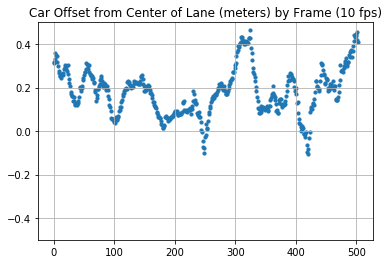

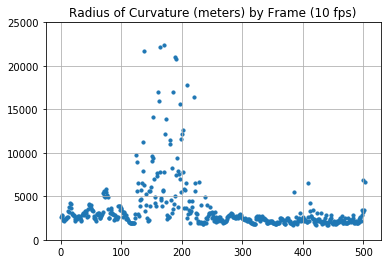

In [17]:
# Explore Radii and Offset Calculations

# Plot the radii measurements
n_pts = len(line_history.left_radii_history)
x_pts = np.array(range(0, n_pts))
left_y_pts = np.log(line_history.left_radii_history)
right_y_pts = np.log(line_history.right_radii_history)
avg_y = np.exp((left_y_pts + right_y_pts) / 2)
#left_spline = spline(x_pts, left_y_pts, np.linspace(0, 25, n_pts))
#right_spline = spline(x_pts, right_y_pts, np.linspace(0, 25, n_pts))

offset_y_pts = line_history.offset_history
print(min(offset_y_pts), max(offset_y_pts))

plt.title('Car Offset from Center of Lane (meters) by Frame (10 fps)')
plt.scatter(x_pts, offset_y_pts, s=10)
plt.grid(True)
plt.ylim(-0.5, 0.5)
plt.show()

plt.title('Radius of Curvature (meters) by Frame (10 fps)')
plt.scatter(x_pts, avg_y, s=10)
plt.grid(True)
plt.ylim(0, 25000)
plt.show()